# 填充和步幅
:label:`sec_padding`

在前面的例子 :numref:`fig_correlation`中，输入的高度和宽度都为$3$，卷积核的高度和宽度都为$2$，生成的输出表征的维数为$2\times2$。
正如我们在 :numref:`sec_conv_layer`中所概括的那样，假设输入形状为$n_h\times n_w$，卷积核形状为$k_h\times k_w$，那么输出形状将是$(n_h-k_h+1) \times (n_w-k_w+1)$。
因此，卷积的输出形状取决于输入形状和卷积核的形状。

还有什么因素会影响输出的大小呢？本节我们将介绍*填充*（padding）和*步幅*（stride）。假设以下情景：
有时，在应用了连续的卷积之后，我们最终得到的输出远小于输入大小。这是由于卷积核的宽度和高度通常大于$1$所导致的。比如，一个$240 \times 240$像素的图像，经过$10$层$5 \times 5$的卷积后，将减少到$200 \times 200$像素。如此一来，原始图像的边界丢失了许多有用信息。而*填充*是解决此问题最有效的方法。
有时，我们可能希望大幅降低图像的宽度和高度。例如，如果我们发现原始的输入分辨率十分冗余。*步幅*则可以在这类情况下提供帮助。

## 填充

如上所述，在应用多层卷积时，我们常常丢失边缘像素。
由于我们通常使用小卷积核，因此对于任何单个卷积，我们可能只会丢失几个像素。
但随着我们应用许多连续卷积层，累积丢失的像素数就多了。
解决这个问题的简单方法即为*填充*（padding）：在输入图像的边界填充元素（通常填充元素是$0$）。
例如，在 :numref:`img_conv_pad`中，我们将$3 \times 3$输入填充到$5 \times 5$，那么它的输出就增加为$4 \times 4$。阴影部分是第一个输出元素以及用于输出计算的输入和核张量元素：
$0\times0+0\times1+0\times2+0\times3=0$。

![带填充的二维互相关。](../img/conv-pad.svg)
:label:`img_conv_pad`

通常，如果我们添加$p_h$行填充（大约一半在顶部，一半在底部）和$p_w$列填充（左侧大约一半，右侧一半），则输出形状将为

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)。$$

这意味着输出的高度和宽度将分别增加$p_h$和$p_w$。

在许多情况下，我们需要设置$p_h=k_h-1$和$p_w=k_w-1$，使输入和输出具有相同的高度和宽度。
这样可以在构建网络时更容易地预测每个图层的输出形状。假设$k_h$是奇数，我们将在高度的两侧填充$p_h/2$行。
如果$k_h$是偶数，则一种可能性是在输入顶部填充$\lceil p_h/2\rceil$行，在底部填充$\lfloor p_h/2\rfloor$行。同理，我们填充宽度的两侧。

卷积神经网络中卷积核的高度和宽度通常为奇数，例如1、3、5或7。
选择奇数的好处是，保持空间维度的同时，我们可以在顶部和底部填充相同数量的行，在左侧和右侧填充相同数量的列。

此外，使用奇数的核大小和填充大小也提供了书写上的便利。对于任何二维张量`X`，当满足：
1. 卷积核的大小是奇数；
2. 所有边的填充行数和列数相同；
3. 输出与输入具有相同高度和宽度
则可以得出：输出`Y[i, j]`是通过以输入`X[i, j]`为中心，与卷积核进行互相关计算得到的。

比如，在下面的例子中，我们创建一个高度和宽度为3的二维卷积层，并(**在所有侧边填充1个像素**)。给定高度和宽度为8的输入，则输出的高度和宽度也是8。


In [4]:
import torch
from torch import nn

#为了方便起见，我们定义了一个计算卷积层的函数
#此函数初始化卷积层权重，并对输入和输出提高和缩减相应的维数
def comp_conv2d(conv2d,X):
    #这里的（1，1）表示批量大小和通道数都是1，1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    #省略前两个维度：批量大小和通道
    return Y.reshape(Y.shape[2:])
# 请注意，这里每边都填充了1行或1列，因此总共添加了2行或2列
conv2d=nn.Conv2d(1,1,kernel_size=3,padding=1)
X=torch.rand(size=(8,8))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

当卷积核的高度和宽度不同时，我们可以填充不同的高度和宽度，使输出和输入具有相同的高度和宽度。在如下示例中，我们使用高度为5，宽度为3的卷积核，高度和宽度两边的填充分别为2和1。

In [5]:
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

## 步幅

在计算互相关时，卷积窗口从输入张量的左上角开始，向下、向右滑动。
在前面的例子中，我们默认每次滑动一个元素。
但是，有时候为了高效计算或是缩减采样次数，卷积窗口可以跳过中间位置，每次滑动多个元素。

我们将每次滑动元素的数量称为*步幅*（stride）。到目前为止，我们只使用过高度或宽度为$1$的步幅，那么如何使用较大的步幅呢？
 :numref:`img_conv_stride`是垂直步幅为$3$，水平步幅为$2$的二维互相关运算。
着色部分是输出元素以及用于输出计算的输入和内核张量元素：$0\times0+0\times1+1\times2+2\times3=8$、$0\times0+6\times1+0\times2+0\times3=6$。

可以看到，为了计算输出中第一列的第二个元素和第一行的第二个元素，卷积窗口分别向下滑动三行和向右滑动两列。但是，当卷积窗口继续向右滑动两列时，没有输出，因为输入元素无法填充窗口（除非我们添加另一列填充）。

![垂直步幅为 $3$，水平步幅为 $2$ 的二维互相关运算。]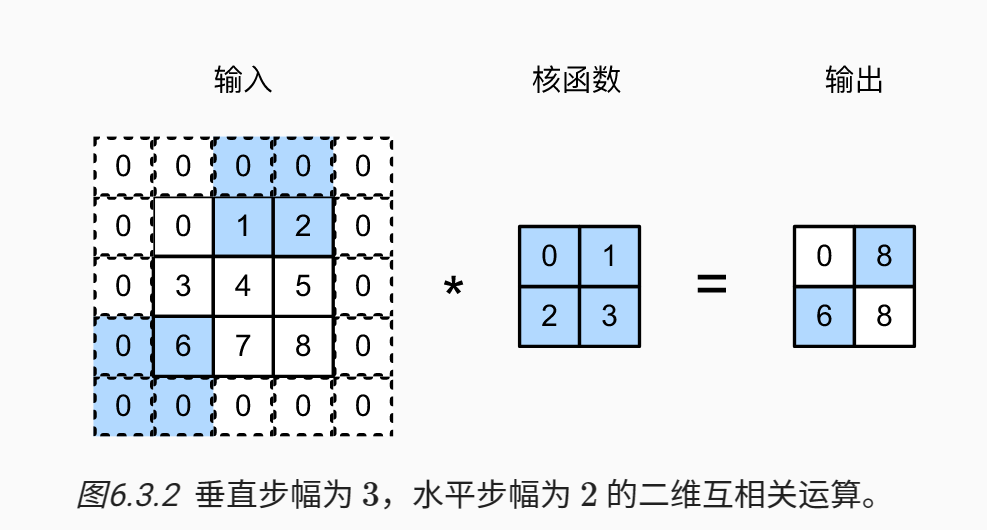
:label:`img_conv_stride`

通常，当垂直步幅为$s_h$、水平步幅为$s_w$时，输出形状为

$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

如果我们设置了$p_h=k_h-1$和$p_w=k_w-1$，则输出形状将简化为$\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$。
更进一步，如果输入的高度和宽度可以被垂直和水平步幅整除，则输出形状将为$(n_h/s_h) \times (n_w/s_w)$。

下面，我们[**将高度和宽度的步幅设置为2**]，从而将输入的高度和宽度减半。


In [6]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [7]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

为了简洁起见，当输入高度和宽度两侧的填充数量分别为$p_h$和$p_w$时，我们称之为填充$(p_h, p_w)$。当$p_h = p_w = p$时，填充是$p$。同理，当高度和宽度上的步幅分别为$s_h$和$s_w$时，我们称之为步幅$(s_h, s_w)$。特别地，当$s_h = s_w = s$时，我们称步幅为$s$。默认情况下，填充为0，步幅为1。在实践中，我们很少使用不一致的步幅或填充，也就是说，我们通常有$p_h = p_w$和$s_h = s_w$。

## 小结

* 填充可以增加输出的高度和宽度。这常用来使输出与输入具有相同的高和宽。
* 步幅可以减小输出的高和宽，例如输出的高和宽仅为输入的高和宽的$1/n$（$n$是一个大于$1$的整数）。
* 填充和步幅可用于有效地调整数据的维度。

## 练习

1. 对于本节中的最后一个示例，计算其输出形状，以查看它是否与实验结果一致。
1. 在本节中的实验中，试一试其他填充和步幅组合。
1. 对于音频信号，步幅$2$说明什么？
1. 步幅大于$1$的计算优势是什么？